## Ejemplo red neuronal DCGAN usando TensorFLow


### Se recomienda ver primero el ejemplo de red neuronal clasificadora, pues muchas cosas básicas de TensorFlow se explican ahí. 

### Una DCGAN (Deep Convolutional Generative Adversarial Network) es un tipo de red neuronal generativa que se basa en la competencia entre dos modelos, el generador y el discriminador. El discriminador recibe elementos reales del dataset (en este caso imágenes) y elementos fabricados, y entrena para poder distinguir cuales son reales y cuales no. El generador, como dice su nombre, genera elementos nuevos, y entrena para lograr engañar al discriminador y hacer pasar sus elementos como elementos originales del dataset. 


Iportante: No se recomienda correr esta red sin una GPU, pues es muy pesada.

### Creación del modelo.


Primero importamos las librerías necesarias y nuestro dataset.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from IPython import display

# Definimos un uso máximo de memoria de GPU
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config=config)


In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalizamos las imagenes a [-1, 1]

In [3]:
# Buffer size determina que tan aleatorio sera nuestro dataset. Para lograr aleatoriedad
# perfecta se debe usar un buffer size mayor al numero de elementos en el dataset
BUFFER_SIZE = 60000

max_size = 16384
# El batch size determina de a cuantos elementos consecutivos agruparemos. 
# Es deseable que el numero de elementos totales sea divisible por el batch size
BATCH_SIZE = 256

# Agrupamos y aleatorizamos nuestro dataset.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

 Esta función crea nuestro modelo discriminador. Este modelo, a diferencia de el modelo clasificador que vimos en el tutorial anterior, tiene una estructura convolucional. Esto significa que sus capas no son planas, sino que tienen alto, largo y ancho, y solo están conectadas con una región de la capa siguiente. genera imagenes a partir de un seed, dando valores numéricos al color de cada pixel.  


 Recibe en su capa inicial un objeto con la forma de nuestras imagenes, en ancho, largo y espectro de colores [28, 28 , 1]. SI las imagenes fueran RGB, la entrada seria  [28, 28 , 3].  

In [4]:
# Tiene una entrada con la forma de nuestras imágenes.
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    # 5,5 es el tamaño de nuestro filtro, que busca patrones en cuadrados de 5 x 5 entradas de una neurona.
    # 64 es la cantidad de filtros que usamos
    # LeakyReLU es la función de activación usada en esta capa
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))        
# Los strides de la capa convolucional representan cuanto se mueve el filtro despues de cada convolucion
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # Dropout convierte una fracción de los inputs recibidos en 0, con el objetivo
    # de evitar overfitting y generar instancias distintas de entrenamiento.
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [5]:
# Creamos nuestro discriminador
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

 A continuación crearemos nuestro modelo generador, que funciona de manera casi opuesta al discriminador. Nuestro modelo es una red con capas convolucionales transpuestas. Mientras que las capas convolucionales toman mucha informacion y la comprimen, las convolucionales transpuestas generan más información a partir de un input pequeño. En este caso, nuestra red toma un seed aleatorio y debe generar un tensor de dimensiones [28, 28, 1], que será nuestra imagen generada.

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) # Esta capa tiene parametros que no podemos entretar
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) 

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

#LLegamos a la forma deseada de nuestra imagen.
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

(None, 28, 28, 1)


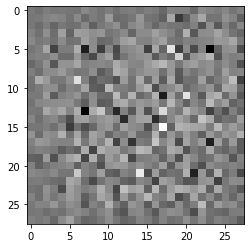

In [7]:
# Creamos nuestro generador y usamos un ejemplo de ruido aleatorio como primera imagen para el modelo discriminador
generator = make_generator_model()
print(generator.output_shape)

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [8]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)        

 Ahora definiremos las funciones de perdida para ambos modelos
 
 Nuestro discriminador busca clasificar las entradas que recibe segun si son imágenes reales o no. Comparamos sus predicciones con 0 si son falsas y 1 si son verdaderas, y esta diferencia es lo que busca minimizar.

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

 Por el otro lado, todas las imágenes generadas son falsas, luego el generador busca que sus imágenes sean clasificadas como verdaderas, por lo que minimizamos la diferencia entre la clasificación de las imagenes y 1

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)



generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
# Creamos checkpoints para la red



checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Entrenamiento.


Acá definiremos nuestro loop de entrenamiento, ademas de un seed que se usara para crear las imágenes.

In [12]:
EPOCHS = 70
noise_dim = 100
num_examples_to_generate = 16


seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [13]:

# El uso de tf.function nos deja compilar la función.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return [gen_loss, disc_loss]

In [14]:
loss_list = []
batch_list_final = []
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    batch_no = 0
    batch_list = []
    gen_loss_sum = 0
    disc_loss_sum = 0
    for image_batch in dataset:
      batch_no += 1
      batch_loss = train_step(image_batch)
      batch_list.append(batch_loss) 
      batch_list_final.append(batch_loss)
    for element in batch_list:
        gen_loss_sum += element[0]
        disc_loss_sum += element[1]
    loss_list.append([gen_loss_sum/batch_no, disc_loss_sum/batch_no])

    # Guardamos imágenes para el GIF final
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Guardamos el modelo cada 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generamos una imagen para el epoch final
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [15]:
# Esta función genera las imagenes
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

 Entrenamos nuestro modelo

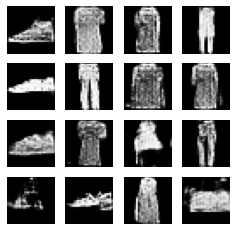

In [16]:
with tf.device('/device:gpu:0'):
    train(train_dataset, EPOCHS)

### Resultados.


A continuación podemos ver la perdida del modelo generador y discriminador, primero por epochs y despues por batches.

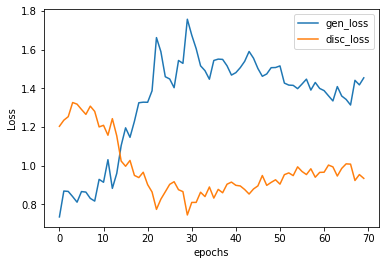

In [17]:
gen_loss, disc_loss = zip(*loss_list)
plt.plot(gen_loss, label='gen_loss')
plt.plot(disc_loss, label = 'disc_loss')
plt.title('')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Loss.pdf")

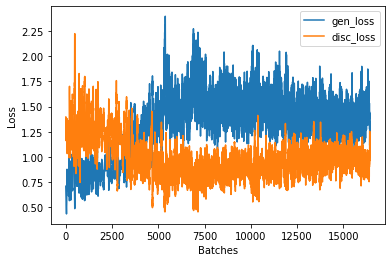

In [18]:
gen_loss_b, disc_loss_b = zip(*batch_list_final)
plt.plot(gen_loss_b, label='gen_loss')
plt.plot(disc_loss_b, label = 'disc_loss')
plt.title('')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.savefig("BatchesLoss.pdf")

Podemos cargar el ultimo checkpoint si es que queremos seguir entrenando

In [27]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

 Usaremos estos elementos generados para crear un gif con el progreso

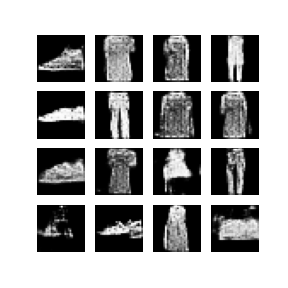

In [19]:

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))



display_image(EPOCHS)

 Finalmente, creamos el gif

In [20]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

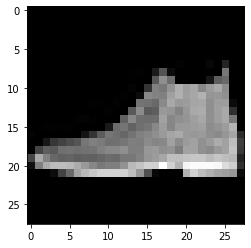

In [21]:
plt.imshow(test_images[0], cmap='gray')
plt.show()

![SegmentLocal](dcgan.gif)